In [1]:
# -- IMPORTS START --
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import seaborn as sns



import pandas as pd
import numpy.typing as npt
import matplotlib.pyplot as plt
from IPython.display import Video
from scipy.spatial.transform import Rotation
import numpy as np
import pandas as pd
import joblib
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, StratifiedKFold
from scipy.spatial.transform import Rotation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz


plt.style.use("seaborn-deep")



# -- IMPORTS END --

# enable zooming into graphs
%matplotlib inline
%matplotlib notebook
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

In [2]:
rotation_matrix_labels = [
        "rotation_matrix_m11",
        "rotation_matrix_m12",
        "rotation_matrix_m13",
        "rotation_matrix_m21",
        "rotation_matrix_m22",
        "rotation_matrix_m23",
        "rotation_matrix_m31",
        "rotation_matrix_m32",
        "rotation_matrix_m33",
    ]

def load_rotation_matrices(data_path: str) -> npt.NDArray[np.float64]:
    """Loads rotation matrices from a dataset csv file."""
    sensor_data = pd.read_csv(data_path)
    return sensor_data[rotation_matrix_labels].values.reshape(-1, 3, 3)

def load_rep_labels(data_path: str) -> npt.NDArray[np.float64]:
    """Loads rep labels from a dataset csv file."""
    sensor_data = pd.read_csv(data_path)
    return sensor_data["rep_count_from_start"].values

def plot_rotation_matrices_with_rep_labels(
    rotation_matrices: npt.NDArray[np.float64], 
    rep_label: npt.NDArray[np.float64]
):
    """Visualizes rotation matrices with rep labels for a dataset sample.
    
    Args:
        rotation_matrices: A numpy array containing the rotation matrices (3D orientation) from the IMU sensor.
        rep_label: A numpy array containing the frame-by-frame rep label.
    """
    fig, ax = plt.subplots(2, 1, figsize=(10, 4), dpi=200)
    ax[0].plot(rep_label % 1);
    ax[0].set_title("Rep Label")
    ax[1].plot(rotation_matrices.reshape(-1, 9), label=[rm.split("_")[-1] for rm in rotation_matrix_labels])
    ax[1].set_title("Rotation Matrices")
    plt.legend(loc = "center right")
    plt.tight_layout()
    plt.show()

In [3]:

# Function to convert rotation matrices to Euler angles and save to a CSV file
def to_euler(input_path, output_path, activity):
    # Load rotation matrices and representation labels
    rotation_matrices = load_rotation_matrices(input_path)
    rep_labels = load_rep_labels(input_path)

    # Covert rotation matrix to Euler angles
    eulers = Rotation.from_matrix(rotation_matrices).as_euler("xyz")
    eulers_df = pd.DataFrame(eulers, columns=["x", "y", "z"])

    # Check if "activity" column exists in the input CSV file
    if "activity" in pd.read_csv(input_path).columns:
        eulers_df["activity"] = pd.read_csv(input_path)["activity"]
    else:
        eulers_df["activity"] = activity

    # Save the Euler angles to the output CSV file
    eulers_df.to_csv(output_path, index=False)

# Function to convert rotational matrices to Euler angles from IMU files given the activity name and file number
def to_euler2(activity_name, file_number, output_file_name):
    # Construct input and output paths based on activity name and file number
    input_path = f"C:/Users/rageg/Downloads/infinityai_imu_fitness_basic_{activity_name}_v1.0/infinityai_imu_fitness_basic_{activity_name}_v1.0/data/{file_number:05d}.csv"
    output_folder = f"C:/Users/rageg/Downloads/CS328 project/{output_file_name}.csv"

    # Load rotation matrices, representation labels, and time column
    rotation_matrices = load_rotation_matrices(input_path)
    rep_labels = load_rep_labels(input_path)
    time_column = pd.read_csv(input_path)["time"]

    # Convert rotation matrix to Euler angles
    eulers = Rotation.from_matrix(rotation_matrices).as_euler("xyz")
    # create a new data frame from the converted 
    eulers_df = pd.DataFrame(eulers, columns=["x", "y", "z"])

    # Add representation labels, time column, and activity column if available
    eulers_df["repFromStart"] = rep_labels
    eulers_df["time"] = time_column
    if "activity" in pd.read_csv(input_path).columns:
        eulers_df["activity"] = pd.read_csv(input_path)["activity"]
    else:
        eulers_df["activity"] = activity_name

    # Save the Euler angles to the output CSV file
    eulers_df.to_csv(output_folder, index=False)

    # Return the generated DataFrame
    return pd.read_csv(output_folder)

# Cache dictionary to store results of concatcsv function
cache = {}

# Function to concatenate Euler angle CSV files for different activities and file numbers
def concatcsv(startIn, endIn, file_path):
    # Check if the result is already in the cache
    cache_key = (startIn, endIn, file_path)
    if cache_key in cache:
        print("Result retrieved from cache.")
        return cache[cache_key]

    # List of activities
    activities = ["pushup", "burpee", "vup", "crunch"]
    concat_data = pd.DataFrame()

    # Loop through each activity and file number, concatenate data, and store in the cache
    for activity in activities:
        modified_endIn = endIn
        activity_data = pd.DataFrame()
        if activity == "crunch":
            modified_endIn = endIn
        if activity == "pushup":
            modified_endIn = endIn
        if activity == "vup":
            modified_endIn = endIn

        for number in range(startIn, modified_endIn):
            file_data = to_euler2(activity, number, f"{activity}_{number}_euler")
            activity_data = pd.concat([activity_data, file_data], ignore_index=True)
            
        #concat and update the newly processed data to the already defined pre-concat data
        concat_data = pd.concat([concat_data, activity_data], ignore_index=True)

    # Save the concatenated data to the specified file path
    concat_data.to_csv(file_path, index=False)

    # Store the result in the cache
    cache[cache_key] = concat_data

    # Return the concatenated data
    return concat_data

    




In [4]:
def calc_magnitude(data):

    # Calculate magnitude  
    data['accel_mag'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2) # absolute accel magnitude
    

    return data

def remove_noise(data,sampling_rate):
    from scipy.signal import butter, filtfilt, find_peaks

    # Low pass filter
    cutoff = 5 # Hz
    order = 2
    b, a = butter(order, cutoff/(sampling_rate/2), btype='lowpass')
    #Applies the filter to the accel_mag column using filtfilt
    data['filtered_accel_mag'] = filtfilt(b, a, data['accel_mag'])

    return data



In [5]:
# Define parameters for data processing
window_size = 50  # Number of data points in each window
window_sec = 2    # Time duration of each window in seconds
sample_rate = 20  # Sampling rate of the data in Hz

In [6]:
 #Function to preprocess data by calculating magnitude, removing noise, and adding a 'rep' column
def preprocess_data(data, sampling_rate=20):
    # Calculate magnitude of the data
    data = calc_magnitude(data)
    
    # Remove noise from the data
    data = remove_noise(data, sampling_rate)
    
    # Convert 'repFromStart' column to integer and assign it to a new 'rep' column
    data['rep'] = data['repFromStart'].astype(int)

    return data

In [7]:
# Function to extract features from data using specified window parameters
'''def extract_features(data, window_size, window_sec, sample_rate=20):
    features_df = pd.DataFrame()

    # Iterate over unique activity labels in the dataset
    for activity_label in data['activity'].unique():

        # Extract data for the current activity
        activity_data = data[data['activity'] == activity_label]

        # Find indices where repetitions change within the activity
        rep_change_indices = np.where(np.diff(activity_data['rep']) > 0)[0]

        # Iterate over repetitions within the activity
        for i in range(len(rep_change_indices)):
            # Start index of the current repetition
            start_idx = rep_change_indices[i - 1] + 1 if i > 0 else 0

            # End index of the current repetition
            end_idx = rep_change_indices[i]

            # Extract data for the current repetition
            rep_data = activity_data.iloc[start_idx:end_idx]

            # Iterate over windows within the repetition
            for j in range(0, len(rep_data) - window_size + 1, 1):
                window_data = rep_data.iloc[j:j + window_size]

                if len(window_data) == window_size:
                    features = {}
                    features['avg'] = window_data['accel_mag'].mean()
                    features['max'] = window_data['accel_mag'].quantile(1)
                    features['med'] = window_data['accel_mag'].quantile(0.5)
                    features['min'] = window_data['accel_mag'].quantile(0)
                    features['q25'] = window_data['accel_mag'].quantile(0.25)
                    features['q75'] = window_data['accel_mag'].quantile(0.75)
                    features['std'] = window_data['accel_mag'].std()

                    features['time_mean'] = window_data['time'].mean()
                    features['time_std'] = window_data['time'].std()
                    features['rep_label_mean'] = window_data['repFromStart'].mean()
                    features['rep_label_std'] = window_data['repFromStart'].std()

                    features['duration'] = window_data['time'].iloc[-1] - window_data['time'].iloc[0]

                    features['activity'] = activity_label

                    features_df = pd.concat([features_df, pd.DataFrame([features])], ignore_index=True)

    features_df.reset_index(drop=True, inplace=True)

    return features_df'''

"def extract_features(data, window_size, window_sec, sample_rate=20):\n    features_df = pd.DataFrame()\n\n    # Iterate over unique activity labels in the dataset\n    for activity_label in data['activity'].unique():\n\n        # Extract data for the current activity\n        activity_data = data[data['activity'] == activity_label]\n\n        # Find indices where repetitions change within the activity\n        rep_change_indices = np.where(np.diff(activity_data['rep']) > 0)[0]\n\n        # Iterate over repetitions within the activity\n        for i in range(len(rep_change_indices)):\n            # Start index of the current repetition\n            start_idx = rep_change_indices[i - 1] + 1 if i > 0 else 0\n\n            # End index of the current repetition\n            end_idx = rep_change_indices[i]\n\n            # Extract data for the current repetition\n            rep_data = activity_data.iloc[start_idx:end_idx]\n\n            # Iterate over windows within the repetition\n       

In [8]:
def extract_features(data, window_size, window_sec, sample_rate):
    features_df = pd.DataFrame()

    # Iterate over the data with the specified window size and step
    for i in range(0, len(data) - window_size + 1, 1):
        window_data = data.iloc[i:i + window_size]

        # Check if the window size is met
        if len(window_data) == window_size:
            features = {}
            features['avg'] = window_data['accel_mag'].mean()
            features['max'] = window_data['accel_mag'].quantile(1)
            features['med'] = window_data['accel_mag'].quantile(0.5)
            features['min'] = window_data['accel_mag'].quantile(0)
            features['q25'] = window_data['accel_mag'].quantile(0.25)
            features['q75'] = window_data['accel_mag'].quantile(0.75)
            features['std'] = window_data['accel_mag'].std()
            features['activity'] = window_data['activity'].iloc[0]

            features_df = pd.concat([features_df, pd.DataFrame([features])], ignore_index=True)

    features_df.reset_index(drop=True, inplace=True)
    return features_df

In [9]:
# Function to train and evaluate a classification model
def train_and_evaluate_model(X, y, classifier=None, test_size=0.4, random_state=42):
    # If classifier is not provided, use DecisionTreeClassifier
    if classifier is None:
        classifier = DecisionTreeClassifier()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the model
    model = classifier
    model.fit(X_train, y_train)

    # Save the trained model to a file
    joblib.dump(model, 'treeModel.pkl')

    # Cross-validation scores, 5 fold cross validation
    cv_scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate accuracy on the testing set
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on the testing set: {accuracy}")

    # Generate and display the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return model

In [10]:
# Function to test a trained classification model on new data
def test_model(model, new_data, title):
    # Preprocess the new data
    new_data = preprocess_data(new_data)

    # Extract features from the preprocessed data
    features_df_new = extract_features(new_data, window_size, window_sec, sample_rate)
    print(features_df_new)

    # Separate features and true labels from the new data
    X_new = features_df_new.drop('activity', axis=1)
    y_true = features_df_new['activity']

    # Make predictions using the trained model
    pred = model.predict(X_new)

    # Evaluate accuracy on the new data
    accuracy_new = accuracy_score(y_true, pred)
    print(f"Accuracy on the testing set: {accuracy_new}")

    # Generate and display the confusion matrix for the new data
    conf_matrix_new = confusion_matrix(y_true, pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_new, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix on: ' + title)
    plt.show()

    return features_df_new






              x         y         z  repFromStart   time activity
0     -1.828495  0.719966 -1.802005      0.000000   0.00   pushup
1     -1.827391  0.764163 -1.798494      0.040886   0.05   pushup
2     -1.777242  0.805475 -1.752962      0.081815   0.10   pushup
3     -1.664050  0.839073 -1.659022      0.122786   0.15   pushup
4     -1.523027  0.852995 -1.544831      0.163798   0.20   pushup
...         ...       ...       ...           ...    ...      ...
46283  2.602327  1.161241  1.215934     14.818634  17.70   crunch
46284  2.599038  1.144663  1.227076     14.856785  17.75   crunch
46285  2.595625  1.131109  1.230788     14.894885  17.80   crunch
46286  2.596716  1.121017  1.233045     14.932932  17.85   crunch
46287  2.604681  1.106801  1.238827     14.970926  17.90   crunch

[46288 rows x 6 columns]
burpee    18188
vup       10936
pushup     9742
crunch     7422
Name: activity, dtype: int64
Cross-Validation Scores: [0.48756488 0.56942042 0.6796064  0.68079585 0.73137234]
Mean Cr

<IPython.core.display.Javascript object>


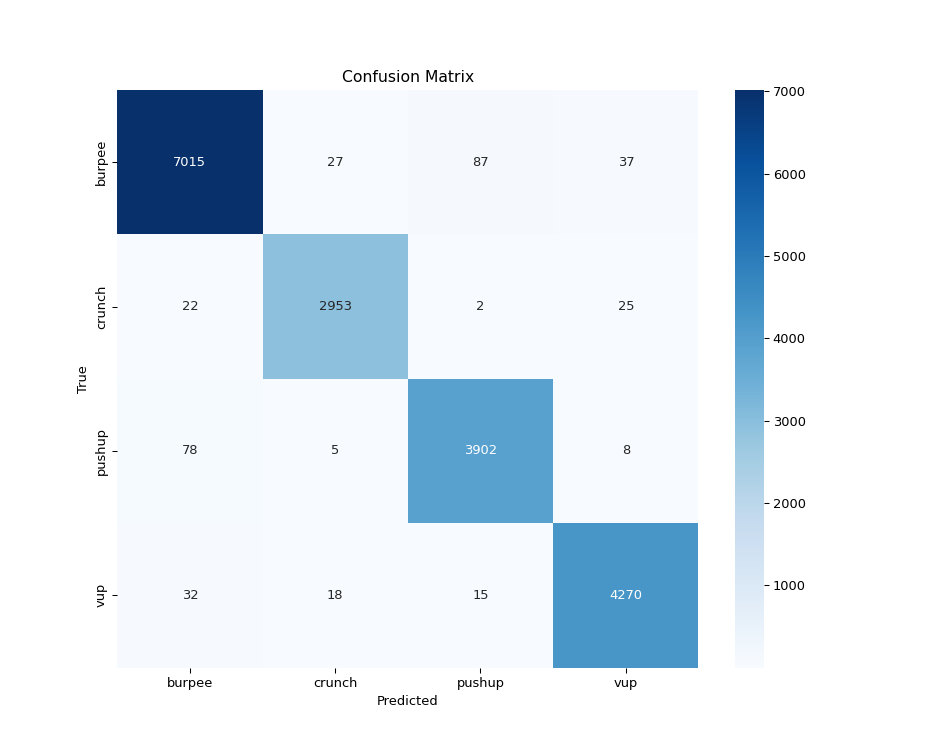

In [11]:
# Concatenate CSV files to create training data, change values to create new combinations
# after downloading IMU dataset and editing directories.
training = concatcsv(0, 25, "C:/Users/rageg/Downloads/CS328 project/new_train.csv")
print(training)

# Count the occurrences of each activity class in the training data
class_count = training["activity"].value_counts()
print(class_count)

# Preprocess the training data
training = preprocess_data(training)

# Extract features from the preprocessed training data
features_df_train = extract_features(training, window_size, window_sec, sample_rate)

# Train and evaluate the model
X_train = features_df_train.drop('activity', axis=1)
y_train = features_df_train['activity']
trained_model = train_and_evaluate_model(X_train, y_train)

            avg       max       med       min       q25       q75       std  \
0      2.151517  2.500337  2.061402  2.000778  2.025076  2.270528  0.159471   
1      2.149833  2.486222  2.061402  2.000778  2.025076  2.270528  0.156123   
2      2.148469  2.468387  2.061402  2.000778  2.025076  2.270528  0.153397   
3      2.147376  2.443225  2.061402  2.000778  2.025076  2.270528  0.151252   
4      2.146560  2.417989  2.061402  2.000778  2.025076  2.270528  0.149725   
...         ...       ...       ...       ...       ...       ...       ...   
19642  3.658626  3.949875  3.677699  3.412555  3.494472  3.808312  0.166130   
19643  3.651445  3.949875  3.642026  3.412555  3.494472  3.799318  0.164406   
19644  3.646746  3.949875  3.610809  3.412555  3.493204  3.799318  0.166543   
19645  3.644257  3.949875  3.610809  3.412555  3.490563  3.799318  0.168782   
19646  3.642728  3.949875  3.610809  3.412555  3.487910  3.799318  0.170371   

      activity  
0       pushup  
1       pushup  


<IPython.core.display.Javascript object>


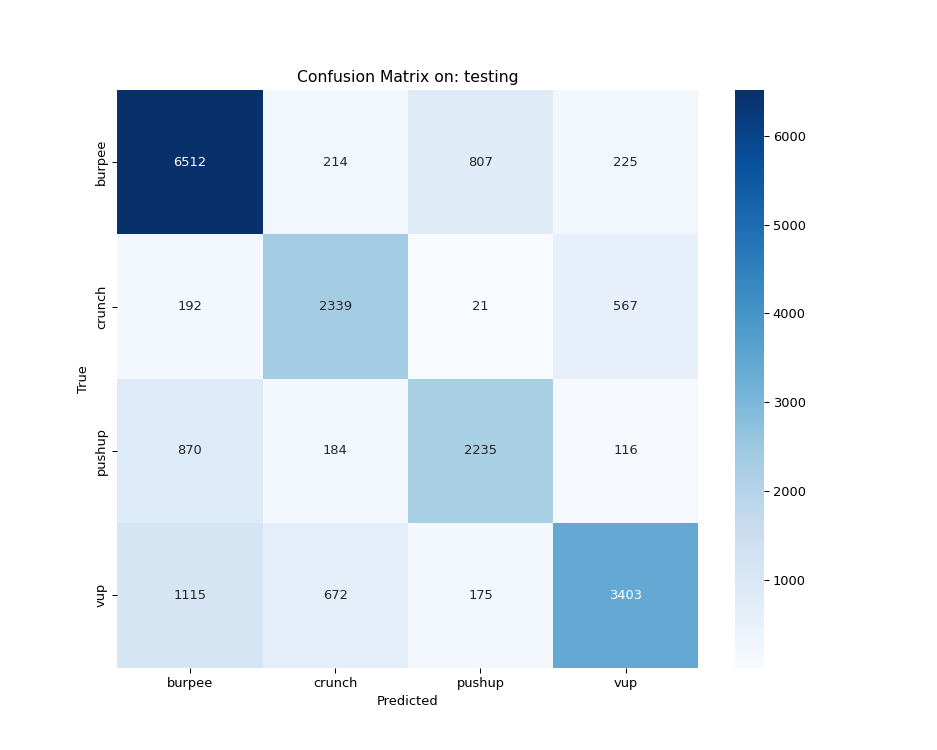

In [12]:
# Concatenate CSV files to create testing data
testing = concatcsv(20, 30, "C:/Users/rageg/Downloads/CS328 project/new_test.csv")

# Test the trained model on the testing data and extract features
features_df_testing = test_model(trained_model, testing, "testing")